## 1 预先准备

In [79]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

from torchvision.datasets import ImageFolder, CIFAR10
from torchvision import transforms as T
from torchvision.transforms import v2

from pytorch_model_summary import summary

from PIL import Image

from time import time

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("whitegrid")

import math
import numpy as np
from torchvision.utils import make_grid
from torchvision.io import read_image

from collections import OrderedDict

from datetime import datetime
from pathlib import Path

import shutil

from scipy.signal import savgol_filter

assert torch.cuda.is_available()
device = "cuda"

data_path = "../../data"

## 2 定义网络类和函数
* `ConvBn()`：返回一个由卷积层、正则化层（可选）、激活层（可选）组成的 `nn.Sequential()`。
* `BottleNeck()`：根据目前的 `config` 和其余参数，返回一个 bottleneck 块。
* `BottleNeckPairs()`：返回若干个 bottleneck 块组成的一个 Stage。
* `ConvNeXt()`：返回一个 ConvNeXt 模型。

可以通过设置 `config`，来获取论文中不同修改阶段（如下图）的模型。

![Fig 2](../learning/fig2.png)

In [80]:
CONFIG_LIST = [
    "stage ratio",      # 0
    "patchify stem",    # 1
    "depth conv",       # 2
    "width up",         # 3
    "inverting dims",   # 4
    "move up d. conv",  # 5
    "kernel sz. to 5",  # 6
    "kernel sz. to 7",  # 7
    "kernel sz. to 9",  # 8
    "kernel sz. to 11", # 9
    "ReLU to GELU",     # 10
    "fewer activations",# 11
    "fewer norms",      # 12
    "BN to LN",         # 13
    "sep. d.s. conv",   # 14
]

def get_nth_config(n):
    return {k: (i <= n) for i, k in enumerate(CONFIG_LIST)}


def ConvBn(in_channels, out_channels, out_map_size, kernel_size=1, stride=1, padding=0, dilation=1, groups=1, norm = None, act = None):
    """
    norm = 'bn': use BN
    norm = 'ln': use LN
    norm = None: do not use normalization

    act = None: do not use activation
    act = 'relu': use RELU
    act = 'gelu': use GELU
    """

    stack = OrderedDict()

    stack[f"{'dconv' if groups > 1 else 'conv'}_{kernel_size}x{kernel_size}"] = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias=False)

    if norm == "bn":
        stack["bn"] = nn.BatchNorm2d(out_channels)
    elif norm == "ln":
        stack["ln"] = nn.LayerNorm([out_channels, out_map_size, out_map_size])

    if act == "relu":
        stack["relu"] = nn.ReLU(inplace=True)
    else:
        stack["gelu"] = nn.GELU()
    return nn.Sequential(stack)
    

class Bottleneck(nn.Module):
    def __init__(self, in_channels, in_map_size, stride, config):
        super().__init__()

        out_channels = in_channels * stride
        out_map_size = in_map_size // stride

        if config["ReLU to GELU"]:
            kernel_size = 7
        elif config["kernel sz. to 11"]:
            kernel_size = 11
        elif config["kernel sz. to 9"]:
            kernel_size = 9
        elif config["kernel sz. to 7"]:
            kernel_size = 7
        elif config["kernel sz. to 5"]:
            kernel_size = 5
        else:
            kernel_size = 3


        if config["move up d. conv"]:
            norm = "ln" if config["BN to LN"] else "bn"
            opt_norm = None if config["fewer norms"] else norm
            act = "gelu" if config["ReLU to GELU"] else "relu"
            opt_act = None if config["fewer activations"] else act

            self.stack = nn.Sequential(
                ConvBn(in_channels, in_channels, out_map_size, kernel_size=kernel_size, stride=stride, padding=kernel_size // 2, groups=in_channels, norm=norm, act=opt_act),
                ConvBn(in_channels, out_channels * 4, out_map_size, kernel_size=1, norm=opt_norm, act=act),
                ConvBn(out_channels * 4, out_channels, out_map_size, kernel_size=1,  norm=opt_norm, act=None),
            )
        elif config["inverting dims"]:
            self.stack = nn.Sequential(
                ConvBn(in_channels, out_channels * 4, in_map_size, kernel_size=1, norm="bn", act="relu"),
                ConvBn(out_channels * 4, out_channels * 4, out_map_size, kernel_size=3, stride=stride, padding=1, groups=out_channels * 4, norm="bn", act="relu"),
                ConvBn(out_channels * 4, out_channels, out_map_size, kernel_size=1,  norm="bn", act=None),
            )
        elif config["depth conv"]:
            self.stack = nn.Sequential(
                ConvBn(in_channels, out_channels // 4, in_map_size, kernel_size=1, norm="bn", act="relu"),
                ConvBn(out_channels // 4, out_channels // 4, out_map_size, kernel_size=3, stride=stride, padding=1, groups=out_channels // 4, norm="bn", act="relu"),
                ConvBn(out_channels // 4, out_channels, out_map_size, kernel_size=1,  norm="bn", act=None),
            )
        else:
            self.stack = nn.Sequential(
                ConvBn(in_channels, out_channels // 4, in_map_size, kernel_size=1, norm="bn", act="relu"),
                ConvBn(out_channels // 4, out_channels // 4, out_map_size, kernel_size=3, stride=stride, padding=1, norm="bn", act="relu"),
                ConvBn(out_channels // 4, out_channels, out_map_size, kernel_size=1,  norm="bn", act=None),
            )

        
        if stride == 1:
            self.shortcut = nn.Identity()
        else:
            self.shortcut = ConvBn(in_channels, out_channels, out_map_size, kernel_size=2, stride=2, norm="ln" if config["BN to LN"] else "bn", act=None)
        
        if config["fewer activations"]:
            self.act = nn.Identity()
        elif config["ReLU to GELU"]:
            self.act = nn.GELU()
        else:
            self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        if self.stack(x).shape != self.shortcut(x).shape:
            print(f'{self.stack = }')
            print(f'{self.shortcut = }')
        return self.act(self.stack(x) + self.shortcut(x))


def BottleNeckPairs(num, in_channels, in_map_size, stride, config):
    return nn.Sequential(
        Bottleneck(in_channels, in_map_size, stride, config),
        *[Bottleneck(in_channels * stride, in_map_size // stride, 1, config) for i in range(num - 1)]
    )


class ConvNeXt(nn.Module):
    def __init__(self, config, image_size, num_classes):
        super().__init__()

        if config["stage ratio"]:
            conv_nums = [3, 3, 9, 3]
        else:
            conv_nums = [3, 4, 6, 3]

        if config["width up"]:
            width = 96
        else:
            width = 64

        use_gelu = config["ReLU to GELU"]
        use_ln = config["BN to LN"]

        if config["patchify stem"]:
            stem = ConvBn(3, width, image_size // 4, kernel_size=4, stride=4, norm="ln" if use_ln else "bn", act="gelu" if use_gelu else "relu")
        else:
            stem = nn.Sequential(OrderedDict([
                ("convbn", ConvBn(3, width, image_size // 2, kernel_size=7, stride=2, padding=3, norm="bn", act="relu")),
                ("maxpool", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
            ]))
        # stem = ConvBn(3, width, image_size // 4, kernel_size=1, stride=1, norm="ln" if use_ln else "bn", act="gelu" if use_gelu else "relu")

        self.stack = nn.Sequential(OrderedDict([
            ("stem", stem),

            ("blockpairs", nn.Sequential(
                BottleNeckPairs(num=conv_nums[0], in_channels=width, in_map_size=image_size // 4, stride=1, config=config),
                BottleNeckPairs(num=conv_nums[1], in_channels=width, in_map_size=image_size // 4, stride=2, config=config),
                BottleNeckPairs(num=conv_nums[2], in_channels=width * 2, in_map_size=image_size // 8, stride=2, config=config),
                BottleNeckPairs(num=conv_nums[3], in_channels=width * 4, in_map_size=image_size // 16, stride=2, config=config),
            )),

            ("avgpool", nn.AvgPool2d(kernel_size=image_size // 32)),
            ("avgpool_flatten", nn.Flatten()),
            ("fc", nn.Linear(in_features=width * 8, out_features=num_classes, bias=True)),
        ]))

        # for module in self.modules():
        #     if isinstance(module, nn.Conv2d):
        #         nn.init.normal_(module.weight, 0, math.sqrt(2) / module.kernel_size[0])
        #     elif isinstance(module, nn.BatchNorm2d):
        #         nn.init.constant_(module.weight, 1)
        #         nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        return self.stack(x)

    def predict_proba(self, x):
        if x.dim() == 3:
            x = x.reshape(1, x.shape[0], x.shape[1], x.shape[2])
        return F.softmax(self.stack(x), dim=1)

## 3 图像处理
使用 CIFAR-10 作为范例，作原论文中的相同处理。

In [81]:
def show_imgs(imgs, labels, nrows, ncols, classes, **kwargs):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, **kwargs)
    for i in range(imgs.shape[0]):
        g = ax[i // ncols, i % ncols]
        g.imshow(torch.maximum(imgs[i], torch.zeros_like(imgs[i])).permute(1, 2, 0))
        g.set_title(f"{classes[labels[i].argmax()]} = {labels[i].max() * 100:.0f}%")
    for i in range(nrows):
        for j in range(ncols):
            ax[i, j].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show(fig)

def timeprint(*args, **kwargs):
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}]", end=' ')
    print(*args, **kwargs)

def data_preprocess(imgs, labels, num_classes):
    assert imgs.dim() == 4

    n = imgs.shape[0]
    new_labels = torch.zeros(( n, num_classes ))

    # One-hot
    for i in range(n):
        new_labels[i][labels[i]] = 1

    new_imgs = imgs.clone()
    
    # Mixup
    MIXUP_ALPHA = 0.8
    lam = torch.asarray(np.random.beta(MIXUP_ALPHA, MIXUP_ALPHA, n))
    index = torch.randperm(n)
    new_imgs = lam.reshape(n, 1, 1, 1) * imgs + (1 - lam).reshape(n, 1, 1, 1) * imgs[index]
    new_labels = lam.reshape(n, 1) * new_labels + (1 - lam).reshape(n, 1) * new_labels[index]

    # Cutmix
    CUTMIX_ALPHA = 1
    lam = np.random.beta(CUTMIX_ALPHA, CUTMIX_ALPHA)
    index = torch.randperm(n)

    height, width = imgs.shape[2], imgs.shape[3]
    ratio = np.sqrt(1 - lam)

    cx = np.random.randint(height - 1)
    cy = np.random.randint(width - 1)

    xl = np.clip(cx - ratio * height // 2, 0, height - 1).astype(int)
    xr = np.clip(cx + ratio * height // 2, 0, height - 1).astype(int)
    yl = np.clip(cy - ratio * width // 2, 0, width - 1).astype(int)
    yr = np.clip(cy + ratio * width // 2, 0, width - 1).astype(int)

    lam = (xr - xl + 1) * (yr - yl + 1) / (height * width)

    timeprint(f"{xl = } {xr = } {yl = } {yr = } {lam = }")

    new_imgs[:, :, xl:xr, yl:yr] = new_imgs[index, :, xl:xr, yl:yr]
    new_labels = (1 - lam) * new_labels + lam * new_labels[index]

    # Label Smoothing
    LABEL_SMOOTHING_ALPHA = 0.1
    new_labels = (1 - LABEL_SMOOTHING_ALPHA) * new_labels + LABEL_SMOOTHING_ALPHA

    # RandAugment and Random Erasing
    transform = T.Compose([
        T.ToPILImage(),
        T.RandAugment(9),
        T.ToTensor(),
        T.RandomErasing(0.25),
    ])
    for i in range(n):
        new_imgs[i] = transform(new_imgs[i])

    return (new_imgs, new_labels)

[2023-08-27 17:09:54] xl = 2 xr = 24 yl = 0 yr = 11 lam = 0.26953125


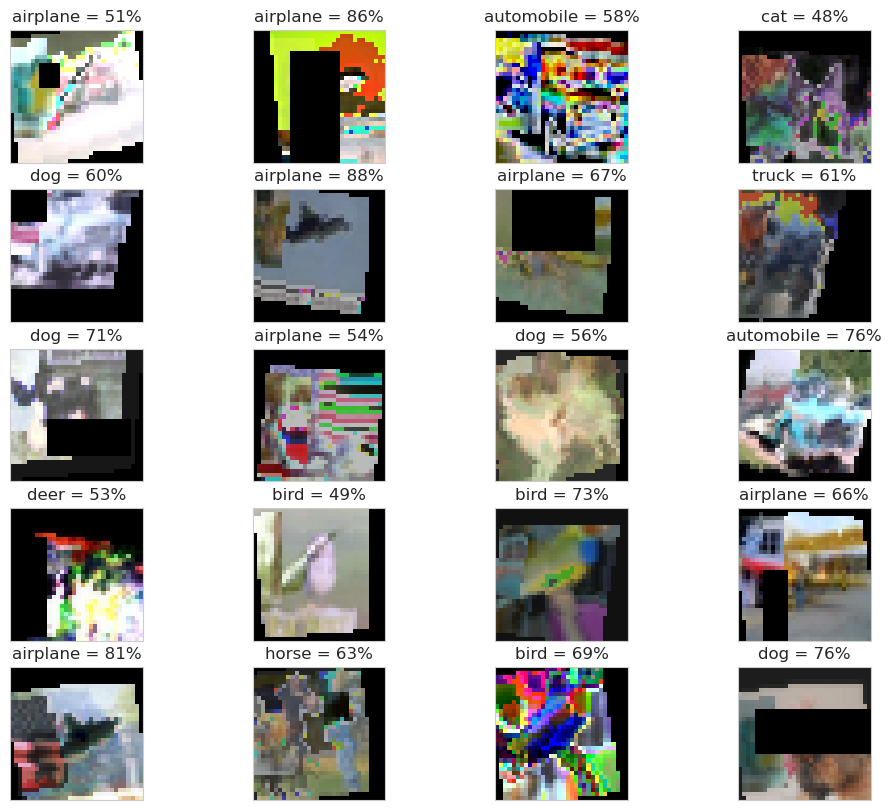

In [82]:
batch_size = 128
real_batch_size = 128




data_full = CIFAR10(root=data_path, train=True, transform=T.ToTensor(), download=False)
classes = data_full.classes

val_indices = []
train_indices = []

val_counts = [500] * 10
for idx, (X, y) in enumerate(data_full):
    if val_counts[y] > 0:
        val_indices.append(idx)
        val_counts[y] -= 1
    else:
        train_indices.append(idx)

train_data = torch.utils.data.Subset(data_full, train_indices)
 
del data_full
del train_data






train_transform = T.Compose([
    T.ToTensor(),
    # T.Resize((64, 64), antialias=True),
])

val_transform = T.Compose([
    T.ToTensor(),
    # T.Resize((64, 64), antialias=True),
])

train_data = CIFAR10(root=data_path, train=True, transform=train_transform, download=False)
train_data = torch.utils.data.Subset(train_data, train_indices)
train_data.classes = classes

val_data = CIFAR10(root=data_path, train=True, transform=val_transform, download=False)
val_data = torch.utils.data.Subset(val_data, val_indices)
val_data.classes = classes

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=1000, shuffle=True, num_workers=4, pin_memory=True)

preview_dataloader = DataLoader(train_data, batch_size=20, shuffle=True)

for X, y in preview_dataloader:
    X, y = data_preprocess(X, y, 10)
    break

show_imgs(X, y, 5, 4, classes, figsize=(12, 10))

## 4 模型参考
可以参照下面的方式，获取不同时期的模型。

In [86]:
# 训练用 optimizer 和 scheduler
# 具体训练代码可以参照 ResNet，然而因为机能不足无法训练，就不在这里贴出了

def get_optimizer(model):
    return torch.optim.AdamW(model.parameters(), lr=4e-3, betas=(0.9, 0.999), weight_decay=0.05)

def get_scheduler(optimizer):
    return torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20)

### 4.1 Baseline

In [84]:
model = ConvNeXt(config=get_nth_config(-1), image_size=256, num_classes=10)
timeprint(summary(model, torch.zeros(1, 3, 256, 256), max_depth=1, show_hierarchical=True))

[2023-08-27 17:09:55] -------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 64, 128, 128]           9,408           9,408
     BatchNorm2d-2     [1, 64, 128, 128]             128             128
            ReLU-3     [1, 64, 128, 128]               0               0
       MaxPool2d-4       [1, 64, 64, 64]               0               0
      Bottleneck-5       [1, 64, 64, 64]           4,544           4,544
      Bottleneck-6       [1, 64, 64, 64]           4,544           4,544
      Bottleneck-7       [1, 64, 64, 64]           4,544           4,544
      Bottleneck-8      [1, 128, 32, 32]          48,768          48,768
      Bottleneck-9      [1, 128, 32, 32]          17,792          17,792
     Bottleneck-10      [1, 128, 32, 32]          17,792          17,792
     Bottleneck-11      [1, 128, 32, 32]          17,792          17,792
     Bottleneck-12      [1, 

### 4.2 最终模型

In [85]:
model = ConvNeXt(config=get_nth_config(14), image_size=256, num_classes=10)
timeprint(summary(model, torch.zeros(1, 3, 256, 256), max_depth=1, show_hierarchical=True))

[2023-08-27 17:09:55] ------------------------------------------------------------------------
      Layer (type)         Output Shape         Param #     Tr. Param #
          Conv2d-1      [1, 96, 64, 64]           4,608           4,608
       LayerNorm-2      [1, 96, 64, 64]         786,432         786,432
            GELU-3      [1, 96, 64, 64]               0               0
      Bottleneck-4      [1, 96, 64, 64]         864,864         864,864
      Bottleneck-5      [1, 96, 64, 64]         864,864         864,864
      Bottleneck-6      [1, 96, 64, 64]         864,864         864,864
      Bottleneck-7     [1, 192, 32, 32]         889,440         889,440
      Bottleneck-8     [1, 192, 32, 32]         697,536         697,536
      Bottleneck-9     [1, 192, 32, 32]         697,536         697,536
     Bottleneck-10     [1, 384, 16, 16]       1,483,968       1,483,968
     Bottleneck-11     [1, 384, 16, 16]       1,395,072       1,395,072
     Bottleneck-12     [1, 384, 16, 16]  